# 1. Set up and load the data

In [1]:
# Set up the required imports.

import time
from functools import partial
from multiprocessing import Pool, cpu_count

import decoupler as dc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
from scipy import stats

from typing import Dict, Tuple, Optional

from anndata import AnnData
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests
from tqdm.auto import tqdm

In [2]:
# Define dataset name.

# DATASET = 'adamson_2016_pilot_curated'
# DATASET = 'adamson_2016_upr_epistasis_curated'
DATASET = 'adamson_2016_upr_perturb_seq_curated'
# DATASET = 'datlinger_2017_curated'
# DATASET = 'orion_2025_hct116_curated'
# DATASET = 'orion_2025_hek293t_curated'

In [3]:
# Copy dataset from storage.

! gsutil cp gs://perturbation-catalogue-lake/perturbseq/curated/{DATASET}.h5ad /tmp/{DATASET}.h5ad

Copying gs://perturbation-catalogue-lake/perturbseq/curated/adamson_2016_upr_perturb_seq_curated.h5ad...
Resuming download for /tmp/adamson_2016_upr_perturb_seq_curated.h5ad component 0
Resuming download for /tmp/adamson_2016_upr_perturb_seq_curated.h5ad component 1
Resuming download for /tmp/adamson_2016_upr_perturb_seq_curated.h5ad component 3
Resuming download for /tmp/adamson_2016_upr_perturb_seq_curated.h5ad component 2
/ [1 files][  1.7 GiB/  1.7 GiB]   34.2 MiB/s                                   
Operation completed over 1 objects/1.7 GiB.                                      


In [4]:
# Load the h5ad file.

adata = sc.read_h5ad(f'/tmp/{DATASET}.h5ad')

/opt/conda/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [5]:
# FIX: adata.var index structure.

adata.var.drop(columns=['gene_symbol'], inplace=True)
adata.var.index.name = 'gene_symbol'
adata.var.reset_index(inplace=True)
adata.var.set_index('gene_symbol', inplace=True)
adata.var['gene_symbol'] = adata.var.index

In [6]:
# FIX: downsample controls.

adata.obs['perturbed_target_symbol'] = adata.obs['perturbed_target_symbol'].str.replace(r'^control.*', 'control', regex=True).astype("category")

In [7]:
# FIX: filter out `nan` perturbations

adata = adata[adata.obs['perturbed_target_symbol'].notna(), :].copy()

In [8]:
# Overview of the file.

adata

AnnData object with n_obs × n_vars = 62611 × 32738
    obs: 'perturbation_name', 'perturbed_target_coord', 'perturbed_target_number', 'perturbed_target_ensg', 'perturbed_target_symbol', 'perturbed_target_biotype', 'guide_sequence', 'perturbation_type_label', 'perturbation_type_id', 'timepoint', 'treatment_label', 'treatment_id', 'model_system_label', 'model_system_id', 'species', 'tissue_label', 'tissue_id', 'cell_type_label', 'cell_type_id', 'cell_line_label', 'cell_line_id', 'sex_label', 'sex_id', 'developmental_stage_label', 'developmental_stage_id', 'disease_label', 'disease_id'
    var: 'ensembl_gene_id', 'gene_symbol'

In [9]:
# High level look at the observations.

adata.obs

,perturbation_name,perturbed_target_coord,perturbed_target_number,perturbed_target_ensg,perturbed_target_symbol,perturbed_target_biotype,guide_sequence,perturbation_type_label,perturbation_type_id,timepoint,...,cell_type_label,cell_type_id,cell_line_label,cell_line_id,sex_label,sex_id,developmental_stage_label,developmental_stage_id,disease_label,disease_id
0,63(mod)_pBA580,NaN,1,control_nontargeting,control,NaN,nan,CRISPRi,NaN,P0DT0H0M0S,...,lymphoblast,CL:0017005,K 562 cell,CLO:0007050,female,NaN,adult,NaN,"chronic myelogenous leukemia, BCR-ABL1 positive",MONDO:0011996
1,OST4_pDS353,chr2:27070472-27071654;-1,1,ENSG00000228474,OST4,protein_coding,GGCTTGTTCGCTGGTGGCGT,CRISPRi,NaN,P0DT0H0M0S,...,lymphoblast,CL:0017005,K 562 cell,CLO:0007050,female,NaN,adult,NaN,"chronic myelogenous leukemia, BCR-ABL1 positive",MONDO:0011996
2,SEC61A1_pDS031,chr3:128051641-128071705;1,1,ENSG00000058262,SEC61A1,protein_coding,GCTGTGCAGTGGAACGCGCT,CRISPRi,NaN,P0DT0H0M0S,...,lymphoblast,CL:0017005,K 562 cell,CLO:0007050,female,NaN,adult,NaN,"chronic myelogenous leukemia, BCR-ABL1 positive",MONDO:0011996
3,EIF2B4_pDS491,chr2:27364352-27370338;-1,1,ENSG00000115211,EIF2B4,protein_coding,GCTGAGGGCGATGGCTGCTG,CRISPRi,NaN,P0DT0H0M0S,...,lymphoblast,CL:0017005,K 562 cell,CLO:0007050,female,NaN,adult,NaN,"chronic myelogenous leukemia, BCR-ABL1 positive",MONDO:0011996
4,SRPR_pDS482,chr11:126262938-126269144;-1,1,ENSG00000182934,SRPRA,protein_coding,GGCGAACGCGGCCTGAATTCC,CRISPRi,NaN,P0DT0H0M0S,...,lymphoblast,CL:0017005,K 562 cell,CLO:0007050,female,NaN,adult,NaN,"chronic myelogenous leukemia, BCR-ABL1 positive",MONDO:0011996
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62618,STT3A_pDS011,chr11:125591712-125625215;1,1,ENSG00000134910,STT3A,protein_coding,GGGAGCCCCGCGGATCGTTT,CRISPRi,NaN,P0DT0H0M0S,...,lymphoblast,CL:0017005,K 562 cell,CLO:0007050,female,NaN,adult,NaN,"chronic myelogenous leukemia, BCR-ABL1 positive",MONDO:0011996
62619,ARHGAP22_pDS458,chr10:48446036-48656265;-1,1,ENSG00000128805,ARHGAP22,protein_coding,GGTCCGTCCGGAGCCAGGAG,CRISPRi,NaN,P0DT0H0M0S,...,lymphoblast,CL:0017005,K 562 cell,CLO:0007050,female,NaN,adult,NaN,"chronic myelogenous leukemia, BCR-ABL1 positive",MONDO:0011996
62620,63(mod)_pBA580,NaN,1,control_nontargeting,control,NaN,nan,CRISPRi,NaN,P0DT0H0M0S,...,lymphoblast,CL:0017005,K 562 cell,CLO:0007050,female,NaN,adult,NaN,"chronic myelogenous leukemia, BCR-ABL1 positive",MONDO:0011996
62621,KCTD16_pDS096,chr5:144170873-144485686;1,1,ENSG00000183775,KCTD16,protein_coding,GGTTTCTCAGACCTAGGTGA,CRISPRi,NaN,P0DT0H0M0S,...,lymphoblast,CL:0017005,K 562 cell,CLO:0007050,female,NaN,adult,NaN,"chronic myelogenous leukemia, BCR-ABL1 positive",MONDO:0011996


In [10]:
# High level look at the genes.

adata.var

,ensembl_gene_id,gene_symbol
gene_symbol,,
MIR1302-10,ENSG00000243485,MIR1302-10
FAM138A,ENSG00000237613,FAM138A
OR4F5,ENSG00000186092,OR4F5
RP11-34P13.7,ENSG00000238009,RP11-34P13.7
RP11-34P13.8,ENSG00000239945,RP11-34P13.8
...,...,...
AC145205.1,ENSG00000215635,AC145205.1
BAGE5,ENSG00000268590,BAGE5
CU459201.1,ENSG00000251180,CU459201.1


# 2. Perturbed genes statistics

Total number of distinct perturbed genes: 89
First 10 perturbed genes: ['OST4', 'SEC61A1', 'EIF2B4', 'SRPRA', 'IER3IP1', 'YIPF5', 'HARS1', 'PRELID3B', 'DAD1', 'TIMM23']


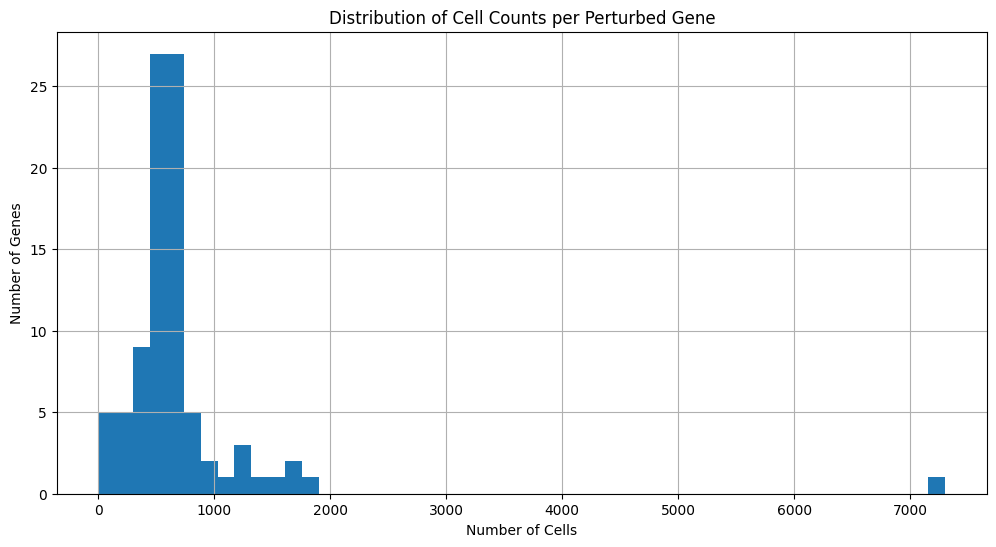


Statistics of cells per perturbed gene:
count      90.000000
mean      695.677778
std       779.742407
min        10.000000
25%       474.500000
50%       590.500000
75%       683.000000
max      7295.000000
Name: count, dtype: float64


In [11]:
# Get all unique perturbation targets (including 'control')
all_targets = adata.obs['perturbed_target_symbol'].unique()

# Filter out 'control' to get only perturbed genes
perturbed_targets = [t for t in all_targets if t != 'control']
num_perturbed_genes = len(perturbed_targets)

print(f"Total number of distinct perturbed genes: {num_perturbed_genes}")
print("First 10 perturbed genes:", perturbed_targets[:10])

# Count number of cells per perturbed gene
target_counts = adata.obs['perturbed_target_ensg'].value_counts()

# Remove 'control' from the counts for plotting
perturbation_counts = target_counts[target_counts.index != 'control']

# Plot histogram
plt.figure(figsize=(12, 6))
perturbation_counts.hist(bins=50)
plt.title('Distribution of Cell Counts per Perturbed Gene')
plt.xlabel('Number of Cells')
plt.ylabel('Number of Genes')
plt.grid(True)
plt.show()

# Show some statistics
print("\nStatistics of cells per perturbed gene:")
print(perturbation_counts.describe())

# 3. Cell type statistics

Total number of distinct cell types: 1
All cell types: ['lymphoblast']
Categories (1, object): ['lymphoblast']


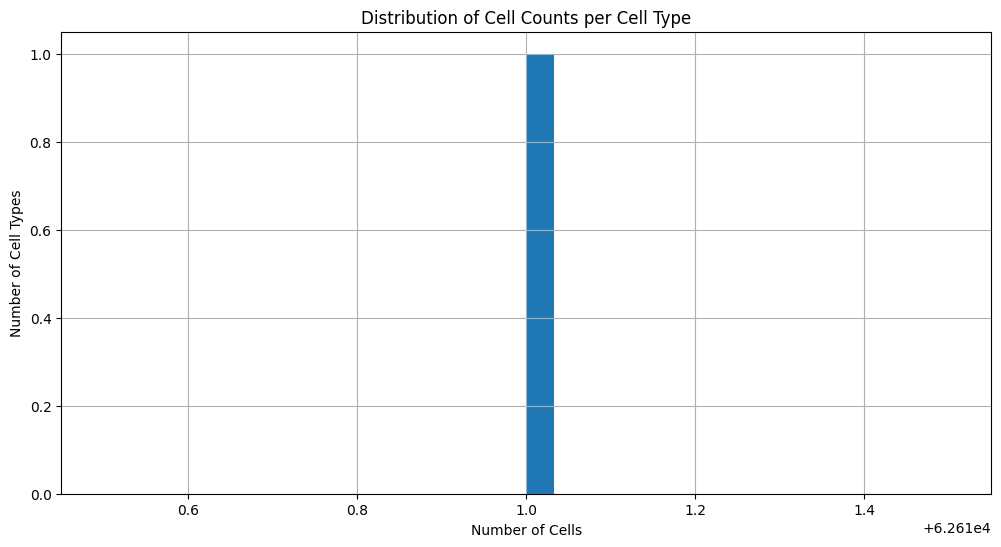

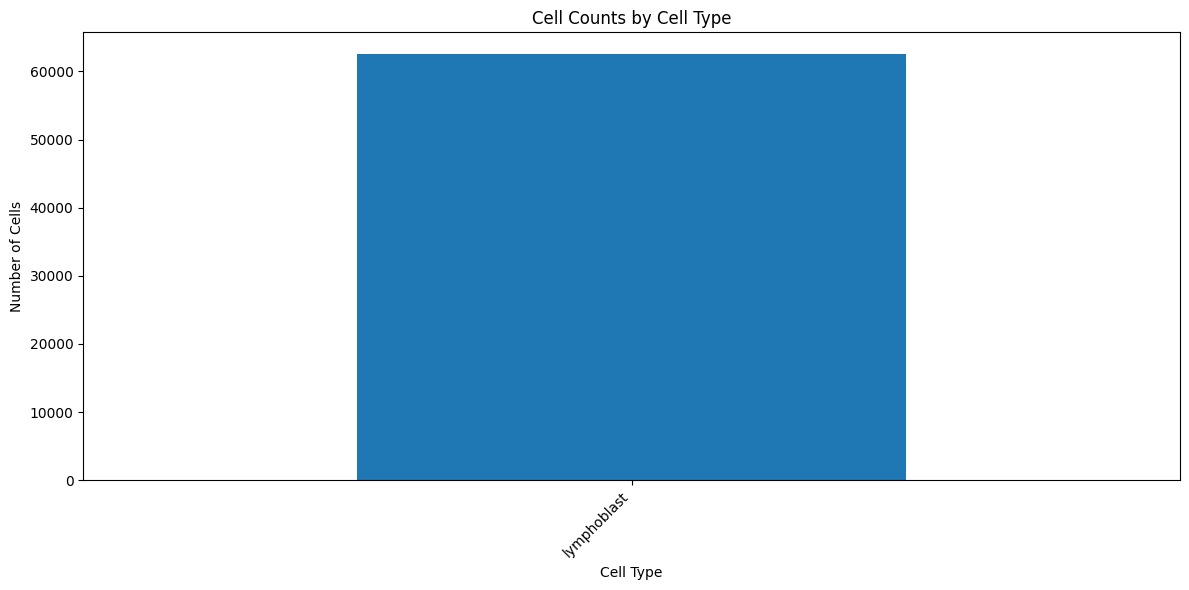


Statistics of cells per cell type:
count        1.0
mean     62611.0
std          NaN
min      62611.0
25%      62611.0
50%      62611.0
75%      62611.0
max      62611.0
Name: count, dtype: float64

Complete cell type distribution:
cell_type_label
lymphoblast    62611
Name: count, dtype: int64


In [12]:
# Get all unique cell types
cell_types = adata.obs['cell_type_label'].unique()
num_cell_types = len(cell_types)

print(f"Total number of distinct cell types: {num_cell_types}")
print("All cell types:", cell_types)

# Count number of cells per cell type
cell_type_counts = adata.obs['cell_type_label'].value_counts()

# Plot histogram
plt.figure(figsize=(12, 6))
cell_type_counts.hist(bins=30)
plt.title('Distribution of Cell Counts per Cell Type')
plt.xlabel('Number of Cells')
plt.ylabel('Number of Cell Types')
plt.grid(True)
plt.show()

# Plot as bar chart for better readability
plt.figure(figsize=(12, 6))
cell_type_counts.sort_values(ascending=False).plot(kind='bar')
plt.title('Cell Counts by Cell Type')
plt.xlabel('Cell Type')
plt.ylabel('Number of Cells')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Show some statistics
print("\nStatistics of cells per cell type:")
print(cell_type_counts.describe())

# Show the complete distribution
print("\nComplete cell type distribution:")
print(cell_type_counts)

# 4. Levels of expression of control genes

Original data shape: (62611, 32738)
Control data shape: (7295, 32738)
Number of genes: 32738
Mean expression range: 0.0000 to 261.1331


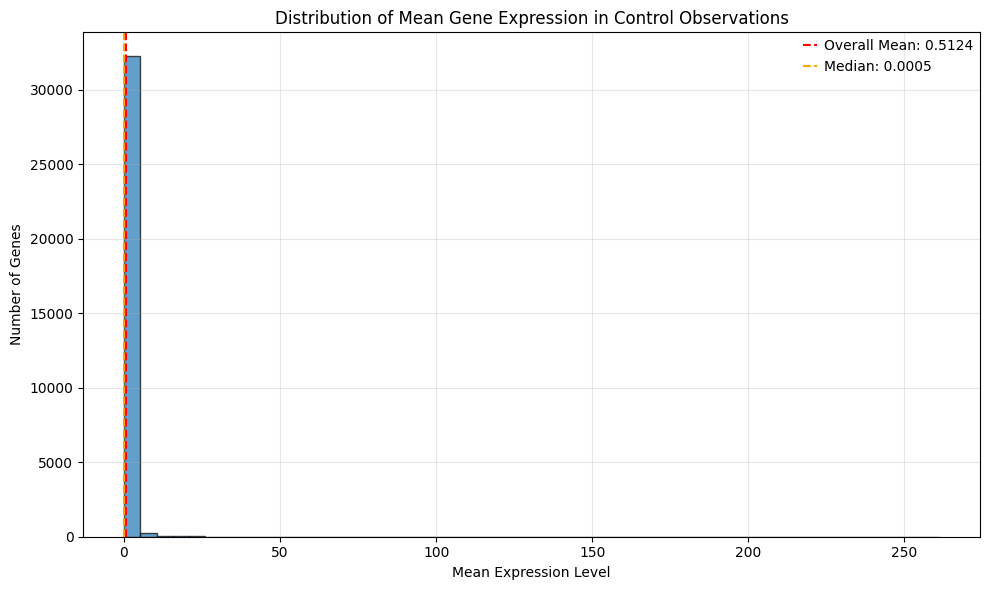


Summary statistics for mean gene expression:
Mean: 0.5124
Median: 0.0005
Standard deviation: 4.6179
25th percentile: 0.0000
75th percentile: 0.1073

Available housekeeping genes and their mean expression:
  RPL13A: 99.0764
  RPLP0: 87.8147
  GAPDH: 40.7215
  ACTB: 36.8047
  B2M: 29.2692
  TUBB: 14.8558
  LDHA: 9.7676
  PPIA: 7.3032
  PGK1: 5.5857
  TFRC: 2.7264
  YWHAZ: 1.6255
  GUSB: 1.2935
  HPRT1: 0.8450
  TBP: 0.2366

Selected highly expressed housekeeping gene: RPL13A (mean: 99.0764)


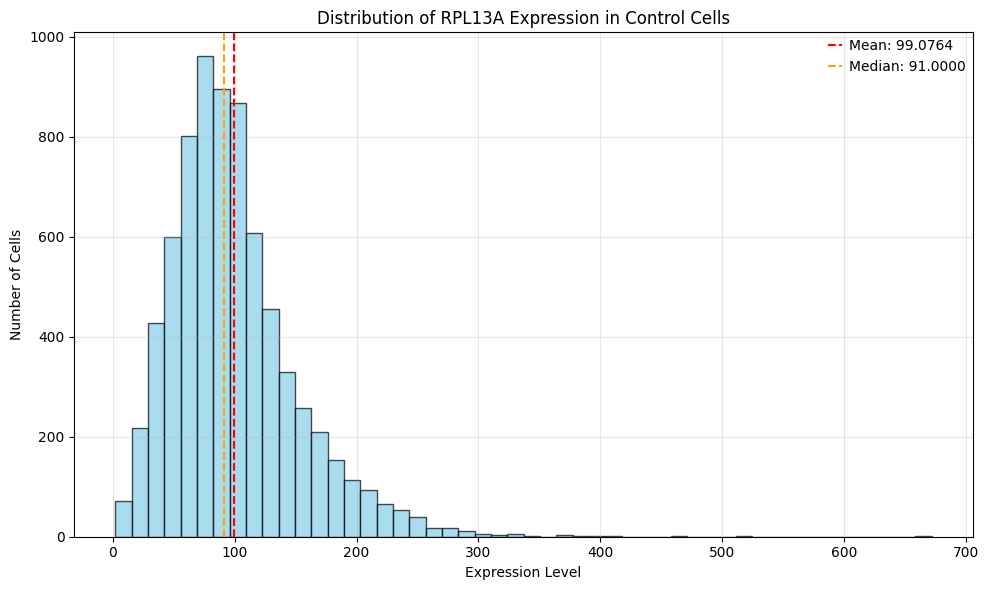


Summary statistics for RPL13A expression:
Mean: 99.0764
Median: 91.0000
Standard deviation: 51.9070
Min: 2.0000
Max: 672.0000
Number of cells: 7295


In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Filter adata to keep only control observations
control_mask = adata.obs['perturbed_target_symbol'] == 'control'
adata_control = adata[control_mask, :].copy()

print(f"Original data shape: {adata.shape}")
print(f"Control data shape: {adata_control.shape}")

# Calculate mean expression per gene across control observations
mean_expression = np.array(adata_control.X.mean(axis=0)).flatten()

print(f"Number of genes: {len(mean_expression)}")
print(f"Mean expression range: {mean_expression.min():.4f} to {mean_expression.max():.4f}")

# Create histogram of mean gene expression values
plt.figure(figsize=(10, 6))
plt.hist(mean_expression, bins=50, alpha=0.7, edgecolor='black')
plt.xlabel('Mean Expression Level')
plt.ylabel('Number of Genes')
plt.title('Distribution of Mean Gene Expression in Control Observations')
plt.grid(True, alpha=0.3)

# Add some summary statistics to the plot
plt.axvline(np.mean(mean_expression), color='red', linestyle='--', 
           label=f'Overall Mean: {np.mean(mean_expression):.4f}')
plt.axvline(np.median(mean_expression), color='orange', linestyle='--', 
           label=f'Median: {np.median(mean_expression):.4f}')
plt.legend()

plt.tight_layout()
plt.show()

# Optional: Print some summary statistics
print(f"\nSummary statistics for mean gene expression:")
print(f"Mean: {np.mean(mean_expression):.4f}")
print(f"Median: {np.median(mean_expression):.4f}")
print(f"Standard deviation: {np.std(mean_expression):.4f}")
print(f"25th percentile: {np.percentile(mean_expression, 25):.4f}")
print(f"75th percentile: {np.percentile(mean_expression, 75):.4f}")

# Find a highly expressed housekeeping gene
housekeeping_genes = ['ACTB', 'GAPDH', 'B2M', 'HPRT1', 'TBP', 'RPLP0', 'RPL13A', 
                      'PPIA', 'YWHAZ', 'GUSB', 'TFRC', 'PGK1', 'LDHA', '18S', 'TUBB']

# Check which housekeeping genes are present in the data
available_hk_genes = []
for gene in housekeeping_genes:
    if gene in adata_control.var.gene_symbol:
        gene_idx = adata_control.var.index.get_loc(gene)
        mean_expr = mean_expression[gene_idx]
        available_hk_genes.append((gene, mean_expr))

if available_hk_genes:
    # Sort by mean expression and pick the highest one
    available_hk_genes.sort(key=lambda x: x[1], reverse=True)
    selected_gene, selected_mean = available_hk_genes[0]
    
    print(f"\nAvailable housekeeping genes and their mean expression:")
    for gene, expr in available_hk_genes:
        print(f"  {gene}: {expr:.4f}")
    
    print(f"\nSelected highly expressed housekeeping gene: {selected_gene} (mean: {selected_mean:.4f})")
    
    # Get expression values for the selected gene across all control cells
    gene_idx = adata_control.var.index.get_loc(selected_gene)
    # Handle both sparse and dense matrices
    if hasattr(adata_control.X, 'toarray'):
        # Sparse matrix
        gene_expression = adata_control.X[:, gene_idx].toarray().flatten()
    else:
        # Dense matrix
        gene_expression = np.array(adata_control.X[:, gene_idx]).flatten()
    
    # Plot distribution of the selected housekeeping gene
    plt.figure(figsize=(10, 6))
    plt.hist(gene_expression, bins=50, alpha=0.7, edgecolor='black', color='skyblue')
    plt.xlabel('Expression Level')
    plt.ylabel('Number of Cells')
    plt.title(f'Distribution of {selected_gene} Expression in Control Cells')
    plt.grid(True, alpha=0.3)
    
    # Add summary statistics to the plot
    plt.axvline(np.mean(gene_expression), color='red', linestyle='--', 
               label=f'Mean: {np.mean(gene_expression):.4f}')
    plt.axvline(np.median(gene_expression), color='orange', linestyle='--', 
               label=f'Median: {np.median(gene_expression):.4f}')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics for the selected gene
    print(f"\nSummary statistics for {selected_gene} expression:")
    print(f"Mean: {np.mean(gene_expression):.4f}")
    print(f"Median: {np.median(gene_expression):.4f}")
    print(f"Standard deviation: {np.std(gene_expression):.4f}")
    print(f"Min: {np.min(gene_expression):.4f}")
    print(f"Max: {np.max(gene_expression):.4f}")
    print(f"Number of cells: {len(gene_expression)}")
    
else:
    print(f"\nNo common housekeeping genes found in the dataset.")
    print("Available gene names (first 20):", list(adata_control.var.gene_symbol[:20]))
    print("You may need to check the gene naming convention (e.g., ENSEMBL IDs vs gene symbols)")

# 5. Pseudobulk differential expression

In [14]:
def _compute_ttest_chunk(args):
    """Helper function for parallel t-test computation"""
    X_control, X_perturbed, gene_indices = args
    pvalues = []
    
    for gene_idx in gene_indices:
        control_vals = X_control[:, gene_idx]
        perturbed_vals = X_perturbed[:, gene_idx]
                
        try:
            _, pval = stats.ttest_ind(perturbed_vals, control_vals)
            pvalues.append(pval)
        except:
            pvalues.append(1.0)
    
    return pvalues

In [15]:
# Helper function for parallel t-test computation
def _compute_ttest_chunk(args):
    """Computes t-tests for a chunk of genes."""
    X_control, X_perturbed, gene_indices = args
    pvalues = []
    for i in gene_indices:
        # Welch's t-test for unequal variances, omits NaNs
        stat, pval = ttest_ind(
            X_control[:, i],
            X_perturbed[:, i],
            equal_var=False,
            nan_policy='omit'
        )
        pvalues.append(pval)
    return pvalues

def compute_pseudobulk_perturbation_analysis(
    adata: AnnData,
    perturbation_col: str = "perturbed_target_symbol",
    cell_type_col: str = "cell_type_label",
    control_label: str = "control",
    min_cells_per_group: int = 10,
    log_transform: bool = True,
    n_jobs: int = -1,
    chunk_size: int = 500,
    min_expression_threshold: float = 10.0
) -> pd.DataFrame:
    """
    Compute pseudobulk analysis for perturbation data, stratified by cell type,
    with parallel processing.

    Parameters:
    -----------
    adata : AnnData
        Annotated data object with perturbation expression results.
    perturbation_col : str
        Column name in adata.obs containing perturbation target symbols.
    cell_type_col : str
        Column name in adata.obs containing cell type or cell line labels.
    control_label : str
        Label used for control/non-targeting samples.
    min_cells_per_group : int
        Minimum number of cells required per perturbation group within each cell type.
    log_transform : bool
        Whether to log-transform the data before analysis.
    n_jobs : int
        Number of parallel jobs (-1 for all cores).
    chunk_size : int
        Number of genes to process per chunk in parallel.
    min_expression_threshold : float
        Minimum pseudobulk control expression to include a gene in the analysis.

    Returns:
    --------
    pd.DataFrame
        Results with columns: cell_type_label, perturbation, gene, log2fc, pvalue,
        padj, mean_control, mean_perturbed.
    """
    start_time = time.time()
    print("Starting pseudobulk analysis...")

    # --- Initial Checks ---
    if perturbation_col not in adata.obs.columns:
        raise ValueError(f"Perturbation column '{perturbation_col}' not found in adata.obs")
    if cell_type_col not in adata.obs.columns:
        raise ValueError(f"Cell type column '{cell_type_col}' not found in adata.obs")

    print(f"✓ Found perturbation column: {perturbation_col}")
    print(f"✓ Found cell type column: {cell_type_col}")

    # --- Data Loading and Transformation ---
    print("📊 Loading expression data...")
    if hasattr(adata.X, 'toarray'):
        X_full = adata.X.toarray()
        print("  Converted sparse matrix to dense")
    else:
        X_full = adata.X

    is_log_transformed = False
    if log_transform and np.max(X_full) > 20:
        print("🔄 Applying log1p transformation to full dataset...")
        X_full = np.log1p(X_full)
        is_log_transformed = True
        print("  ✓ Log transformation complete")
    elif np.max(X_full) <= 20:
        is_log_transformed = True
        print("  Data appears already log-transformed or log_transform=False")
    else:
        print("  log_transform=False")


    # --- Main Loop for Cell Types ---
    unique_cell_types = adata.obs[cell_type_col].unique()
    print(f"Found {len(unique_cell_types)} unique cell types: {', '.join(unique_cell_types)}")
    all_results = []

    for cell_type in unique_cell_types:
        print(f"\n{'='*20}\nProcessing Cell Type: {cell_type}\n{'='*20}")
        
        ct_mask = adata.obs[cell_type_col] == cell_type
        adata_ct = adata[ct_mask, :].copy()
        X = X_full[ct_mask, :]
        
        print(f"Dataset shape for {cell_type}: {adata_ct.shape}")

        print("🏷️  Processing perturbation labels...")
        perturbations = adata_ct.obs[perturbation_col].values
        unique_perturbations = np.unique(perturbations)
        print(f"  Found {len(unique_perturbations)} unique perturbations in {cell_type}")

        print(f"🔍 Filtering perturbations (min {min_cells_per_group} cells)...")
        valid_perturbations = []
        for pert in unique_perturbations:
            cell_count = np.sum(perturbations == pert)
            if cell_count >= min_cells_per_group:
                valid_perturbations.append(pert)
                print(f"  ✓ {pert}: {cell_count} cells")
            else:
                print(f"  ✗ Skipping {pert}: only {cell_count} cells")
        
        if not valid_perturbations or control_label not in valid_perturbations:
            print(f"  ⚠️ Control label '{control_label}' not found or has too few cells in {cell_type}. Skipping.")
            continue

        print(f"✓ Will analyze {len(valid_perturbations)} perturbations for {cell_type}")

        print("🧮 Computing pseudobulk...")
        pseudobulk_data = {
            pert: np.mean(X[perturbations == pert, :], axis=0)
            for pert in valid_perturbations
        }
        pseudobulk_df = pd.DataFrame(pseudobulk_data, index=adata_ct.var_names)
        print(f"✓ Pseudobulk computed. Shape: {pseudobulk_df.shape}")

        control_expression = pseudobulk_df[control_label].values
        control_mask = perturbations == control_label
        X_control = X[control_mask, :]
        
        num_of_control_cells = X_control.shape[0]

        if is_log_transformed:
            threshold_to_use = np.log1p(min_expression_threshold)
        else:
            threshold_to_use = min_expression_threshold
        
        print(f"🔍 Filtering genes with total control expression > {threshold_to_use:.2f} (using {num_of_control_cells} control cells)")
        expressed_genes_mask = (control_expression * num_of_control_cells) > threshold_to_use
        n_expressed = np.sum(expressed_genes_mask)

        if n_expressed == 0:
            print(f"  ⚠️ No genes passed expression threshold for control in {cell_type}. Skipping.")
            continue
        print(f"  ✓ {n_expressed}/{len(control_expression)} genes pass expression threshold")

        # Create a list of perturbations to process (excluding the control)
        perturbations_to_process = [p for p in valid_perturbations if p != control_label]

        # Loop with a tqdm progress bar instead of verbose printing
        for pert in tqdm(perturbations_to_process, desc=f"Analyzing perturbations in {cell_type}", unit="pert"):
            
            perturbed_mask = perturbations == pert
            X_perturbed = X[perturbed_mask, :]

            control_expr_filtered = control_expression[expressed_genes_mask]
            perturbed_expr_filtered = pseudobulk_df[pert].values[expressed_genes_mask]
            X_control_filtered = X_control[:, expressed_genes_mask]
            X_perturbed_filtered = X_perturbed[:, expressed_genes_mask]
            expressed_gene_names = adata_ct.var.index[expressed_genes_mask].tolist()
            
            pseudocount = 1e-8
            log2fc = np.log2((perturbed_expr_filtered + pseudocount) / (control_expr_filtered + pseudocount))

            n_genes_filtered = X_control_filtered.shape[1]
            gene_chunks = [list(range(i, min(i + chunk_size, n_genes_filtered))) for i in range(0, n_genes_filtered, chunk_size)]
            args_list = [(X_control_filtered, X_perturbed_filtered, chunk) for chunk in gene_chunks]

            with Pool(n_jobs if n_jobs != -1 else cpu_count()) as pool:
                chunk_results = pool.map(_compute_ttest_chunk, args_list)
            
            pvalues = np.array([pval for chunk in chunk_results for pval in chunk])
            
            valid_pvals = ~np.isnan(pvalues)
            padj = np.full_like(pvalues, np.nan)
            if np.sum(valid_pvals) > 0:
                _, padj_valid, _, _ = multipletests(pvalues[valid_pvals], method='fdr_bh')
                padj[valid_pvals] = padj_valid

            for i, gene_name in enumerate(expressed_gene_names):
                all_results.append({
                    'cell_type_label': cell_type,
                    'perturbation': pert,
                    'gene': str(gene_name),
                    'log2fc': log2fc[i],
                    'pvalue': pvalues[i],
                    'padj': padj[i],
                    'mean_control': control_expr_filtered[i],
                    'mean_perturbed': perturbed_expr_filtered[i]
                })

    print("\n📋 Finalizing results...")
    if not all_results:
        print("⚠️ No results were generated. This could be due to insufficient cells or no genes passing the expression filter in any cell type.")
        return pd.DataFrame()

    results_df = pd.DataFrame(all_results)
    results_df = results_df.sort_values(['cell_type_label', 'perturbation', 'pvalue'])
    
    total_time = time.time() - start_time
    print(f"\n🎉 Analysis complete! Total time: {total_time:.2f} seconds")
    print(f"   Analyzed {results_df['cell_type_label'].nunique()} cell types")
    print(f"   Analyzed {results_df['perturbation'].nunique()} unique perturbations")
    print(f"   Total comparisons: {len(results_df):,}")
    
    return results_df

In [16]:
def plot_volcano_plot(results_df, perturbation_name, 
                     pval_threshold=0.05, fc_threshold=1.0, 
                     top_n_genes=10):
    """
    Create a volcano plot for a specific perturbation.
    
    Parameters:
    -----------
    results_df : pd.DataFrame
        Results from compute_pseudobulk_perturbation_analysis
    perturbation_name : str
        Name of the perturbation to plot
    pval_threshold : float
        P-value threshold for significance
    fc_threshold : float
        Fold change threshold (absolute log2 fold change)
    top_n_genes : int
        Number of top genes to label
    """
    import matplotlib.pyplot as plt
    
    # Filter for specific perturbation
    pert_data = results_df[results_df['perturbation'] == perturbation_name].copy()
    
    if len(pert_data) == 0:
        print(f"No data found for perturbation: {perturbation_name}")
        print(f"Available perturbations: {results_df['perturbation'].unique()}")
        return
    
    # Remove rows with NaN values for plotting
    pert_data = pert_data.dropna(subset=['padj', 'log2fc'])
    
    if len(pert_data) == 0:
        print(f"No valid data points for perturbation: {perturbation_name} after removing NaN values")
        return
    
    print(f"Plotting {len(pert_data)} genes for {perturbation_name}")
    
    # Create significance categories
    pert_data['significant'] = (pert_data['padj'] < pval_threshold) & (np.abs(pert_data['log2fc']) > fc_threshold)
    
    print(f"Found {np.sum(pert_data['significant'])} significant genes")
    
    # Create plot
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Plot non-significant points
    non_sig = pert_data[~pert_data['significant']]
    if len(non_sig) > 0:
        ax.scatter(non_sig['log2fc'], -np.log10(non_sig['padj']), 
                  alpha=0.5, color='gray', s=20, label=f'Non-significant ({len(non_sig)})')
    
    # Plot significant points
    sig = pert_data[pert_data['significant']]
    if len(sig) > 0:
        ax.scatter(sig['log2fc'], -np.log10(sig['padj']), 
                  alpha=0.7, color='red', s=30, label=f'Significant ({len(sig)})')
    
    # Add threshold lines
    ax.axhline(-np.log10(pval_threshold), color='blue', linestyle='--', alpha=0.5, 
               label=f'padj = {pval_threshold}')
    ax.axvline(fc_threshold, color='blue', linestyle='--', alpha=0.5)
    ax.axvline(-fc_threshold, color='blue', linestyle='--', alpha=0.5)
    
    # Label top genes (by most significant padj)
    top_genes = pert_data.nsmallest(top_n_genes, 'padj')
    for _, gene in top_genes.iterrows():
        if not np.isnan(gene['padj']) and gene['padj'] > 0:  # Only label if valid padj
            ax.annotate(gene['gene'], 
                       (gene['log2fc'], -np.log10(gene['padj'])),
                       xytext=(5, 5), textcoords='offset points',
                       fontsize=8, alpha=0.8)
    
    ax.set_xlabel('Log2 Fold Change')
    ax.set_ylabel('-Log10 Adjusted P-value')
    ax.set_title(f'Volcano Plot: {perturbation_name}')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Add some statistics to the plot
    stats_text = f"Total genes: {len(pert_data)}\n"
    stats_text += f"Significant: {np.sum(pert_data['significant'])}\n"
    stats_text += f"FC threshold: ±{fc_threshold}\n"
    stats_text += f"padj threshold: {pval_threshold}"
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8), fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    # Print some summary statistics
    print(f"\nSummary for {perturbation_name}:")
    print(f"  Total genes plotted: {len(pert_data)}")
    print(f"  Significant genes: {np.sum(pert_data['significant'])}")
    print(f"  Mean |log2FC|: {np.mean(np.abs(pert_data['log2fc'])):.3f}")
    print(f"  Min padj: {np.min(pert_data['padj']):.2e}")
    if len(sig) > 0:
        print(f"  Top significant gene: {sig.loc[sig['padj'].idxmin(), 'gene']} (padj={sig['padj'].min():.2e})")

In [ ]:
# Run the analysis

results = compute_pseudobulk_perturbation_analysis(
    adata, 
    perturbation_col="perturbed_target_symbol",
    control_label="control",
    min_cells_per_group=10,
    n_jobs=-1,  # Use all available cores
    chunk_size=500,  # Process 500 genes per chunk
    min_expression_threshold=10.0  # Only analyze genes with control expression > 10
)

Starting pseudobulk analysis...
✓ Found perturbation column: perturbed_target_symbol
✓ Found cell type column: cell_type_label
📊 Loading expression data...
  Converted sparse matrix to dense
🔄 Applying log1p transformation to full dataset...
  ✓ Log transformation complete
Found 1 unique cell types: lymphoblast

Processing Cell Type: lymphoblast
Dataset shape for lymphoblast: (62611, 32738)
🏷️  Processing perturbation labels...
  Found 90 unique perturbations in lymphoblast
🔍 Filtering perturbations (min 10 cells)...
  ✓ AARS1: 447 cells
  ✓ ACOD1: 281 cells
  ✓ AMIGO3: 715 cells
  ✓ ARHGAP22: 490 cells
  ✓ ASCC3: 1756 cells
  ✓ ATF4: 353 cells
  ✓ ATF6: 10 cells
  ✓ ATP5F1B: 644 cells
  ✓ CARS1: 501 cells
  ✓ CCL13: 1230 cells
  ✓ CCND3: 397 cells
  ✓ CHERP: 479 cells
  ✓ COPB1: 225 cells
  ✓ COPZ1: 282 cells
  ✓ DAD1: 752 cells
  ✓ DARS1: 664 cells
  ✓ DDOST: 382 cells
  ✓ DDRGK1: 607 cells
  ✓ DERL2: 656 cells
  ✓ DHDDS: 507 cells
  ✓ DNAJC19: 1525 cells
  ✓ EIF2AK3: 161 cells
  ✓ E

Analyzing perturbations in lymphoblast:   0%|          | 0/89 [00:00<?, ?pert/s]

In [ ]:
results

In [ ]:
# Display summary

print(f"Analyzed {results['perturbation'].nunique()} perturbations")
print(f"Total comparisons: {len(results)}")

In [ ]:
# Check for NaN padj values

nan_padj = results['padj'].isna().sum()
if nan_padj > 0:
    print(f"Warning: {nan_padj} entries have NaN adjusted p-values")

In [ ]:
# Show top results for each perturbation

for pert in results['perturbation'].unique():
    print(f"\nTop 10 most significant genes for {pert}:")
    pert_results = results[results['perturbation'] == pert]
    # Filter out NaN padj for display
    pert_results_clean = pert_results.dropna(subset=['padj'])
    if len(pert_results_clean) > 0:
        top5 = pert_results_clean.nsmallest(10, 'padj')[['gene', 'log2fc', 'pvalue', 'padj']]
        print(top5.to_string(index=False))
    else:
        print("  No valid results (all padj are NaN)")

In [ ]:
# Create volcano plot for a specific perturbation
plot_volcano_plot(results, perturbed_targets[0])

In [ ]:
# Save results
results.to_csv(f"/tmp/{DATASET}.csv", index=False)

In [ ]:
# Upload to Google Storage.
! gsutil cp /tmp/{DATASET}.csv gs://perturbation-catalogue-lake/perturbseq/differential_expression/{DATASET}.csv